# Diễn giải mô hình hồi quy bằng SHAP

### BS. Lê Ngọc Khả Nhi


# Giới thiệu

SHAP (SHapley Additive exPlanations) là một phương pháp diễn giải mô hình hiện đại, được xem như phổ quát và hiệu quả nhất hiện nay để diễn giải mô hình, vì nó có thể áp dụng cho bất kì dạng algorithm/bài toán nào và cung cấp nhiều thông tin hữu ích. 

Cơ chế của SHAP dựa vào Shapley's score trong lý thuyết trò chơi và kết hợp với một số kỹ thuật diễn giải mô hình hiện đại khác. Cơ chế này có thể được trình bày đơn giản như sau: 

Bài toán phân loại hoặc hồi quy sẽ được xem như một trò chơi có tính đồng đội/hợp tác mà mục tiêu là đạt được kết quả chính xác nhất có thể; các features được xem như những người chơi.

Quy trình SHAP sẽ lần lượt cho mỗi feature kết hợp ngẫu nhiên với những features khác để tạo thành 1 đội và hợp sức tạo ra kết quả cho 1 trường hợp, mỗi feature (người chơi) sẽ được thưởng 1 số điểm tùy theo thành tích đóng góp vào kết quả chung của toàn đội. Cuối cùng, ta tính được điểm số SHAP cho 1 feature xác định, là kết quả trung bình của tất cả lượng thay đổi trên kết quả dự báo mà 1 đội đạt được, khi feature đó tham gia vào đội. 

Như vậy, SHAP score đo lường sự đóng góp trung bình của mỗi feature trên toàn bộ những khả năng kết hợp (tạo đội nhóm) có thể giữa các features.

Phương pháp này được áp dụng vào Python qua package shap: 
https://github.com/slundberg/shap

Tài liệu tham khảo:
https://www.nature.com/articles/s42256-019-0138-9.epdf


Install shap:
pip install shap

hay

conda install -c conda-forge shap

Trong bài thực hành này, Nhi sẽ giới thiệu với các bạn về tất cả những hình thức đồ họa thống kê mà shap cung cấp, để áp dụng diễn giải cho một bài toán hồi quy sử dụng blackbox model.

# Bài toán minh họa: Parkinson telemonitoring

Để minh họa, Nhi sử dụng dataset Parkinson telemonitoring từ thư viện UCI. Dữ liệu gồm 5,875 instance trên 42 bệnh nhân.

Bài toán này đặt ra mục tiêu ước lượng 1 điểm số đánh giá chức năng vận động trên bệnh nhân Parkinson, dựa vào tuổi, giới tính và 16 features trích xuất từ tín hiệu âm thanh ghi nhận qua 1 cảm biến theo dõi từ xa.

Thông tin từ trang UCI:

Source:

The dataset was created by Athanasios Tsanas (tsanasthanasis '@' gmail.com) and Max Little (littlem '@' physics.ox.ac.uk) of the University of Oxford, in collaboration with 10 medical centers in the US and Intel Corporation who developed the telemonitoring device to record the speech signals. The original study used a range of linear and nonlinear regression methods to predict the clinician's Parkinson's disease symptom score on the UPDRS scale.

Data Set Information:

This dataset is composed of a range of biomedical voice measurements from 42 people with early-stage Parkinson's disease recruited to a six-month trial of a telemonitoring device for remote symptom progression monitoring. The recordings were automatically captured in the patient's homes.

Columns in the table contain subject number, subject age, subject gender, time interval from baseline recruitment date, motor UPDRS, total UPDRS, and 16 biomedical voice measures. Each row corresponds to one of 5,875 voice recording from these individuals. The main aim of the data is to predict the motor and total UPDRS scores ('motor_UPDRS' and 'total_UPDRS') from the 16 voice measures.

The data is in ASCII CSV format. The rows of the CSV file contain an instance corresponding to one voice recording. There are around 200 recordings per patient, the subject number of the patient is identified in the first column. For further information or to pass on comments, please contact Athanasios Tsanas (tsanasthanasis '@' gmail.com) or Max Little (littlem '@' physics.ox.ac.uk).

Further details are contained in the following reference -- if you use this dataset, please cite:
Athanasios Tsanas, Max A. Little, Patrick E. McSharry, Lorraine O. Ramig (2009),
'Accurate telemonitoring of Parkinson’s disease progression by non-invasive speech tests',
IEEE Transactions on Biomedical Engineering (to appear).

Further details about the biomedical voice measures can be found in:
Max A. Little, Patrick E. McSharry, Eric J. Hunter, Lorraine O. Ramig (2009),
'Suitability of dysphonia measurements for telemonitoring of Parkinson's disease',
IEEE Transactions on Biomedical Engineering, 56(4):1015-1022 


subject# - Integer that uniquely identifies each subject

age - Subject age

sex - Subject gender '0' - male, '1' - female

test_time - Time since recruitment into the trial. The integer part is the number of days since recruitment.

motor_UPDRS - Clinician's motor UPDRS score, linearly interpolated

total_UPDRS - Clinician's total UPDRS score, linearly interpolated

Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP - Several measures of variation in fundamental frequency

Shimmer,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA - Several measures of variation in amplitude

NHR,HNR - Two measures of ratio of noise to tonal components in the voice

RPDE - A nonlinear dynamical complexity measure

DFA - Signal fractal scaling exponent

PPE - A nonlinear measure of fundamental frequency variation

# Thí nghiệm :

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Ignore warnings
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import *

# Bước 1: Chuẩn bị dữ liệu

Nhi tải dữ liệu parkinson_telemonitoring định dạng csv từ OpenML database

In [2]:
df = pd.read_csv('https://www.openml.org/data/get_csv/1798093/phpFBxu1w.csv')

df

,subject.,age,sex,test_time,motor_UPDRS,total_UPDRS,Jitter...,Jitter.Abs.,Jitter.RAP,Jitter.PPQ5,...,Shimmer.dB.,Shimmer.APQ3,Shimmer.APQ5,Shimmer.APQ11,Shimmer.DDA,NHR,HNR,RPDE,DFA,PPE
0,1,72,0,5.6431,28.199,34.398,0.00662,0.000034,0.00401,0.00317,...,0.230,0.01438,0.01309,0.01662,0.04314,0.014290,21.640,0.41888,0.54842,0.16006
1,1,72,0,12.6660,28.447,34.894,0.00300,0.000017,0.00132,0.00150,...,0.179,0.00994,0.01072,0.01689,0.02982,0.011112,27.183,0.43493,0.56477,0.10810
2,1,72,0,19.6810,28.695,35.389,0.00481,0.000025,0.00205,0.00208,...,0.181,0.00734,0.00844,0.01458,0.02202,0.020220,23.047,0.46222,0.54405,0.21014
3,1,72,0,25.6470,28.905,35.810,0.00528,0.000027,0.00191,0.00264,...,0.327,0.01106,0.01265,0.01963,0.03317,0.027837,24.445,0.48730,0.57794,0.33277
4,1,72,0,33.6420,29.187,36.375,0.00335,0.000020,0.00093,0.00130,...,0.176,0.00679,0.00929,0.01819,0.02036,0.011625,26.126,0.47188,0.56122,0.19361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5870,42,61,0,142.7900,22.485,33.485,0.00406,0.000031,0.00167,0.00168,...,0.160,0.00973,0.01133,0.01549,0.02920,0.025137,22.369,0.64215,0.55314,0.21367
5871,42,61,0,149.8400,21.988,32.988,0.00297,0.000025,0.00119,0.00147,...,0.215,0.01052,0.01277,0.01904,0.03157,0.011927,22.886,0.52598,0.56518,0.12621
5872,42,61,0,156.8200,21.495,32.495,0.00349,0.000025,0.00152,0.00187,...,0.244,0.01371,0.01456,0.01877,0.04112,0.017701,25.065,0.47792,0.57888,0.14157
5873,42,61,0,163.7300,21.007,32.007,0.00281,0.000020,0.00128,0.00151,...,0.131,0.00693,0.00870,0.01307,0.02078,0.007984,24.422,0.56865,0.56327,0.14204


Dữ liệu có 42 bệnh nhân, mã hóa ở cột subject, do mỗi bệnh nhân được lấy mẫu nhiều lần nên ta sẽ phân chia train/test set dựa vào subject ID, sao cho mỗi bệnh nhân chỉ tham gia vào train set hoặc test set. 

Việc phân chia theo subject rất dễ dàng, ta không cần chia ngẫu nhiên mà có thể dựa vào ID của bệnh nhân:

Ở đây Nhi tạo train set từ 32 bệnh nhân đầu tiên (4396 instances), và test set từ các bệnh nhân 33 đến 42 (1479 instances)

In [3]:
df['subject.'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42], dtype=int64)

In [6]:
train_df = df[df['subject.'].isin([i+1 for i in range(32)])]
test_df = df.loc[train_df.shape[0]:]

train_df.shape, test_df.shape

((4396, 22), (1479, 22))

Bài toán này có 2 outcome, nhưng ta chỉ làm hồi quy cho outcome total_UPDRS, phân phối của chúng như sau:

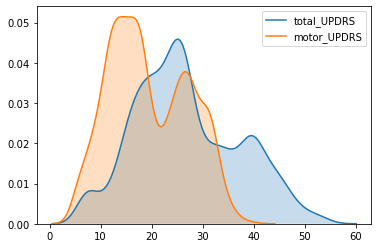

In [5]:
sns.kdeplot(data = train_df['total_UPDRS'], shade = True)
sns.kdeplot(data = train_df['motor_UPDRS'], shade = True)

Xem thông tin của tập train set

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4396 entries, 0 to 4395
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   subject.       4396 non-null   int64  
 1   age            4396 non-null   int64  
 2   sex            4396 non-null   int64  
 3   test_time      4396 non-null   float64
 4   motor_UPDRS    4396 non-null   float64
 5   total_UPDRS    4396 non-null   float64
 6   Jitter...      4396 non-null   float64
 7   Jitter.Abs.    4396 non-null   float64
 8   Jitter.RAP     4396 non-null   float64
 9   Jitter.PPQ5    4396 non-null   float64
 10  Jitter.DDP     4396 non-null   float64
 11  Shimmer        4396 non-null   float64
 12  Shimmer.dB.    4396 non-null   float64
 13  Shimmer.APQ3   4396 non-null   float64
 14  Shimmer.APQ5   4396 non-null   float64
 15  Shimmer.APQ11  4396 non-null   float64
 16  Shimmer.DDA    4396 non-null   float64
 17  NHR            4396 non-null   float64
 18  HNR     

Input features gồm 18 biến: 2 cột sex, age, và 16 cột từ Jitter... đến PPE

In [8]:
input_feats = ['age', 'sex'] + list(df.columns[6:])

X_train, X_test,y_train,y_test = train_df[input_feats], test_df[input_feats], \
                                 train_df['total_UPDRS'], test_df['total_UPDRS']

Kiểm tra lại lần cuối cấu trúc dữ liệu dùng trong thí nghiệm Machine learning:

In [9]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(4396, 18) (4396,) (1479, 18) (1479,)


# Dựng mô hình hồi quy XGboost

Ta đang phải giải quyết 1 bài toán hồi quy, mục tiêu là ước lượng outcome total_UPDRS là 1 đại lượng dương, liên tục.

Nhi chọn algorithm XGboost cho bài toán này vì những lý do:

- Tốc độ huấn luyện nhanh (hỗ trợ tính toán GPU)
- Độ chính xác cao (theo kinh nghiệm cho thấy...)
- Không cần xử lý dữ liệu đầu vào (chọn lọc features, chuẩn hóa...)
- Mô hình cây cho phép học được quy luật phi tuyến tính

Cấu trúc của mô hình XGboost như sau:

Mục tiêu là ước lượng outcome theo phân phối Gamma, hàm loss là gamma -nloglikelihood.

Lưu ý: chọn booster là 'gbtree' chứ không nên dùng 'dart', vì shap chỉ tương thích với gbtree, nếu ta muốn dùng shap để diễn giải mô hình.

Nếu bạn không có GPU, không cần khai báo tree_method, predictor

Chọn hyper parameter theo kinh nghiệm

In [34]:
from xgboost import XGBRegressor

xgb_mod = XGBRegressor(objective = 'reg:gamma',
                       n_estimators = 2000,
                       n_round = 3000,
                       gamma = 0.001,
                       learning_rate = 0.01,
                       max_depth = 5,
                       min_child_weight = 1,
                       subsample = 0.75,
                       colsample_bytree = 0.8,
                       colsample_bylevel = 0.8,
                       grow_policy = "lossguide",
                       tree_method = 'gpu_hist',
                       eval_metric = 'gamma-nloglik',
                       booster = 'gbtree',
                       predictor = 'gpu_predictor')

xgb_mod.fit(X_train.values, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.8,
             colsample_bynode=1, colsample_bytree=0.8,
             eval_metric='gamma-nloglik', gamma=0.001, gpu_id=0,
             grow_policy='lossguide', importance_type='gain',
             interaction_constraints=None, learning_rate=0.01, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints=None, n_estimators=2000, n_jobs=0,
             n_round=3000, num_parallel_tree=1, objective='reg:gamma',
             predictor='gpu_predictor', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=None, subsample=0.75,
             tree_method='gpu_hist', validate_parameters=False, ...)

Mô hình được huấn luyện khá nhanh chóng, ta sẽ thử áp dụng cho tập test set:

Ta thấy kết quả hồi quy không được hoàn hảo, với median absolute error = 11.87.

Có vẻ như mô hình tái hiện tốt khuynh hướng trung tâm của outcome, nhưng ước lượng không chính xác những giá trị thấp và cao tại 2 cực của thang đo

In [36]:
pred = xgb_mod.predict(X_test.values)

median_absolute_error(y_test,pred)

11.867146545410158

[Text(0.5, 0, 'total_UPDRS')]

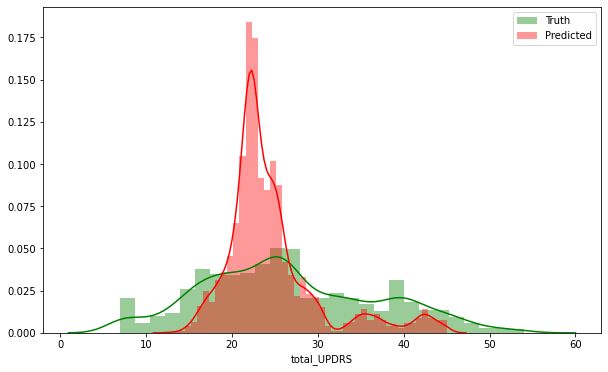

In [37]:
plt.rcParams["figure.figsize"] = (10,6)

g = sns.distplot(y_train.values,
            label = 'Truth',
            color = 'green')

g = sns.distplot(pred,
            label = 'Predicted',
            color = 'red')

g.legend()
g.set(xlabel='total_UPDRS')

# Bước 3: Giải nghia mô hình bằng shap

Đâu tiên, Nhi tải package shap và kích hoạt module đồ họa Javascript của shap

In [17]:
import shap
shap.initjs()

Quy trình diễn giải mô hình bắt đầu bằng việc tạo ra 1 explainer object. shap cung cấp nhiều algorithm explainer khác nhau nhưng ở đây do ta dùng mô hình cây (XGboost, Random Forest là mô hình cây tập hợp), nên Nhi chọn dùng TreeExplainer.

Sau khi có explainer object, ta áp dụng cho features trong test set để sinh ra tập giá trị shap_values, 

In [38]:
explainer = shap.TreeExplainer(xgb_mod)
shap_values = explainer.shap_values(X_test)

Việc diễn giải mô hình với shap chủ yếu là qua đồ họa thống kê, dĩ nhiên các bạn có thể xuất các trị số thống kê và tùy thích sử dụng chúng theo cách mình muốn, nhưng đồ họa vẫn là giải pháp tối ưu để minh họa trực quan và đơn giản.

## Biểu đồ Variable importance

Dạng biểu đồ thứ nhất cho phép ta khảo sát vai trò của các features, hay khả năng đóng góp của chúng vào kết quả của mô hình. 

Biểu đồ này được dựng qua hàm summary_plot. 

Cấu tạo của biểu đồ như sau:

Trục X là thang đo shap score, 

Trục Y là danh sách các features, được xếp thứ hạng tùy vào tầm quan trọng, cao nhất là feature quan trọng nhất.

Một yếu tố hình họa (điểm, cột, violin, có thể tùy chỉnh) cho phép khảo sát phân bố của shap score cho mỗi feature, và so sánh chúng. 

Giá trị mỗi feature được chuẩn hóa về 1 thang đo biểu kiến, được trình bày trên phổ màu bên phải. Người dùng có thể tùy chỉnh phổ màu này theo ý thích.

### Dạng biểu đồ điểm:

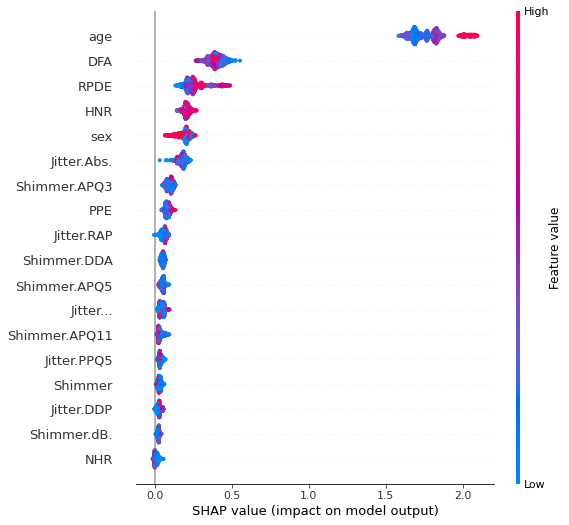

In [108]:
shap.summary_plot(shap_values, 
                  X_test,
                  feature_names= X_test.columns,
                 show=True,
                 sort = True,
                 auto_size_plot= True)

### Dạng violin

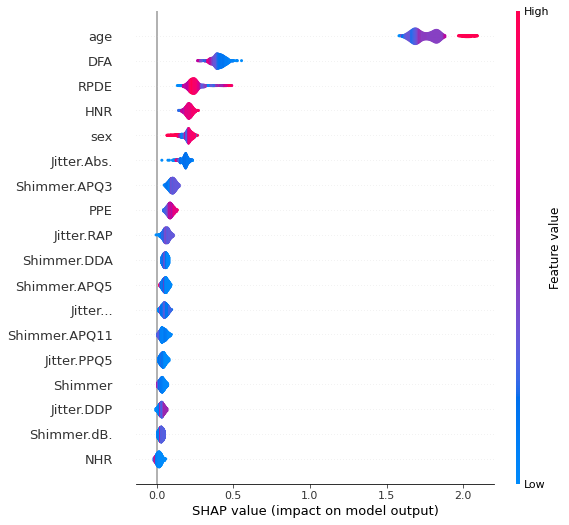

In [170]:
shap.summary_plot(shap_values, 
                  X_test,
                  plot_type = 'violin',
                  feature_names= X_test.columns,
                 show=True,
                 sort = True,
                 auto_size_plot= True)

### Dạng violin phân lớp

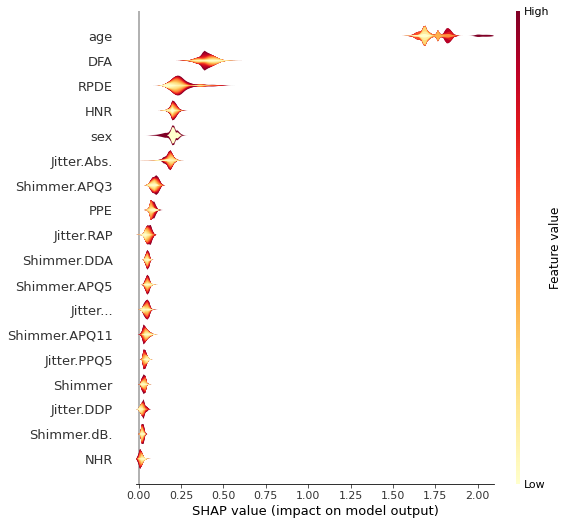

In [167]:
shap.summary_plot(shap_values, 
                  X_test,
                  plot_type = 'layered_violin',
                  feature_names= X_test.columns,
                 show=True,
                 sort = True,
                 auto_size_plot= True,
                 color='YlOrRd')

### Biểu đồ thanh (cột)

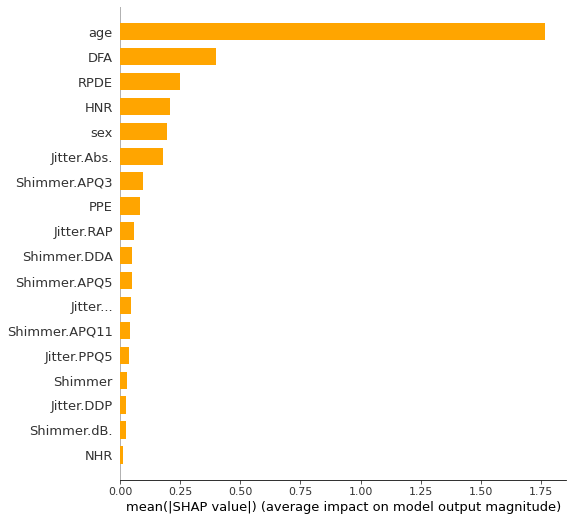

In [134]:
shap.summary_plot(shap_values, 
                  X_test,
                  plot_type = 'bar',
                  color = 'orange',
                  feature_names= X_test.columns,
                 show=True,
                 sort = True,
                 auto_size_plot= True)

##  Biểu đồ waterfall

Tiếp theo, ta có biểu đồ waterfall dựng bằng hàm waterfall_plot, công dụng của biểu đồ này nhằm diễn giải kết quả dự báo mô hình cho từng cá thể, đồng thời đánh giá luôn mức độ đóng góp/tầm quan trọng của mỗi features cho riêng cá thể đó.

Cấu tạo của biểu đồ gồm:

+ Trục X hiển thị thang đo của hàm f(X) cho bài toán hồi quy (cho bài toán phân loại, dùng link function là logit để biểu thị xác suất dự báo, có giá trị giới hạn trong khoảng 0-1).

+ Trục Y sắp xếp features theo độ quan trọng, nhằm đánh giá khả năng đóng góp vào kết quả dự báo

Tương ứng với mỗi features là giá trị của features đó cho cá thể đang khảo sát

Yếu tố hình họa sử dụng biểu đồ thanh (cột), nhằm đo lường và so sánh độ đóng góp vào kết quả hàm f(X) cho mỗi features.

Feature càng quan trọng thì kích thước bar càng dài, 

Trên mỗi bar được dán nhãn giá trị shap score, dấu +/- cho biết vai trò của features làm tăng hay giảm kết quả hàm f(X)

Ta có thể thấy mỗi feature đã đóng góp mạnh yếu khác nhau vào kết quả hàm f(X), khi đưa lần lượt từng features, từ yếu nhất đến mạnh nhất, giá trị f(X) sẽ tăng hoặc giảm cho đến khi đạt giá trị sau cùng chính là kết quả dự báo cho cá thể đó.

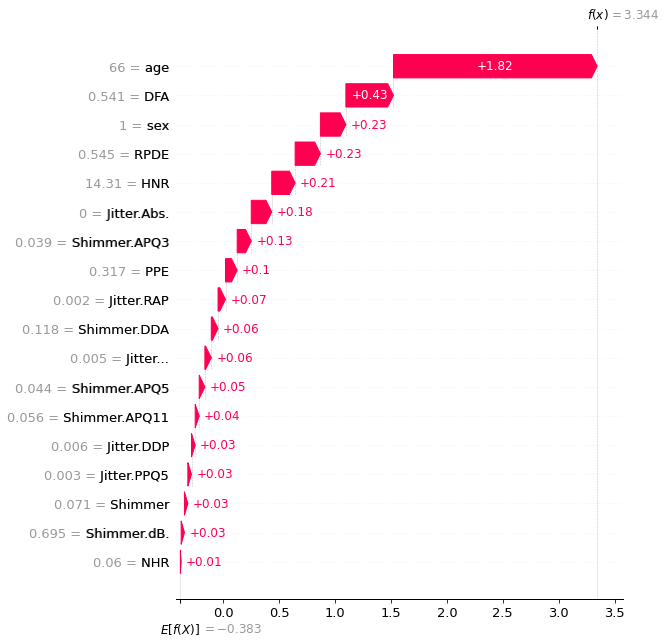

In [41]:
case = 100

shap.waterfall_plot(explainer.expected_value, 
                    shap_values[case], 
                    X_test.iloc[case], 
                    max_display=22)

## Biểu đồ tương quan bộ phận

Dạng biểu đồ tiếp theo mà shap cung cấp là Biểu đồ tương quan bộ phận, dựng bằng hàm partial_dependence_plot. 

Công dụng của nó nhằm khảo sát mối liên hệ bộ phận giữa 1 feature bất kì và kết quả của hàm f(X) (kết quả dự báo).

Biểu đồ này có cấu tạo như sau:

+ Trục X biểu thị thang đo của feature được khảo sát, người dùng có thể tùy chỉnh giới hạn của thang đo này trong khoảng 2 bách phân vị tùy ý, một histogram sẽ được dựng lên để khảo sát phân bố của feature trong giới hạn này.

+ Trục Y biểu thị thang đo của hàm f(X), một cách độc lập với những features còn lại

+ Từ 2 thang đo này, một biểu đồ tuyến kí (màu xanh) sẽ được dựng, biểu thị quy luật/khuynh hướng phụ thuộc của hàm f(Xi) và feature Xi. Nếu bạn dùng 1 mô hình tuyến tính, đồ thị sẽ tuyến tính, nhưng ở đây ta dùng mô hình cây nên hàm f(X) là phi tuyến tính.

Người dùng có thể khảo sát 1 cá thể xác định qya argument 'shap_values = shap_values[id]', ở đây id = 100 chỉ case thứ 100 trong test set. Giá trị của Xi và f(Xi) cho riêng cá thể đó sẽ được định vị trên đồ thị

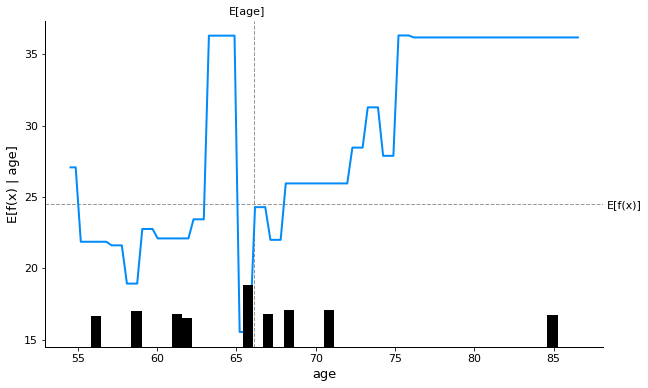

In [67]:
shap.partial_dependence_plot(
    ind = 'age',
    model = xgb_mod.predict,
    features = X_test.values,
    shap_values = shap_values[100],
    # shap_value_features = X_test,
    feature_names= X_test.columns,
    xmin = 'percentile(5)',
    xmax = 'percentile(95)',
    model_expected_value=True,
    feature_expected_value=True)

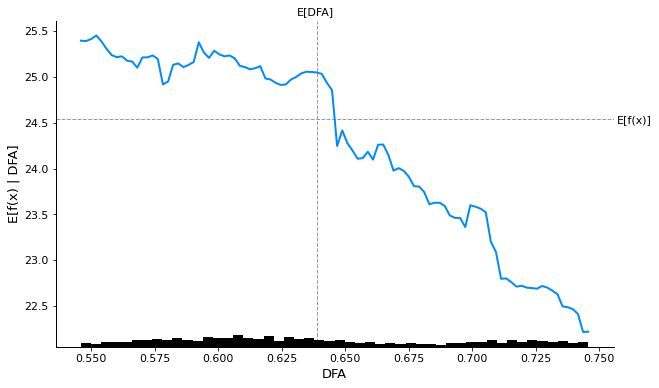

In [65]:
shap.partial_dependence_plot(
    ind = 'DFA',
    model = xgb_mod.predict,
    features = X_test.values,
    shap_values = shap_values[100],
    feature_names= X_test.columns,
    xmin = 'percentile(5)',
    xmax = 'percentile(95)',
    model_expected_value=True,
    feature_expected_value=True)

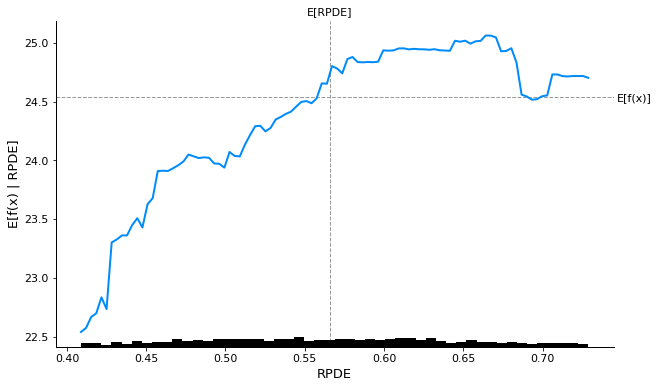

In [64]:
shap.partial_dependence_plot(
    ind = 'RPDE',
    model = xgb_mod.predict,
    features = X_test.values,
    shap_values = shap_values[100],
    feature_names= X_test.columns,
    xmin = 'percentile(5)',
    xmax = 'percentile(95)',
    model_expected_value=True,
    feature_expected_value=True)

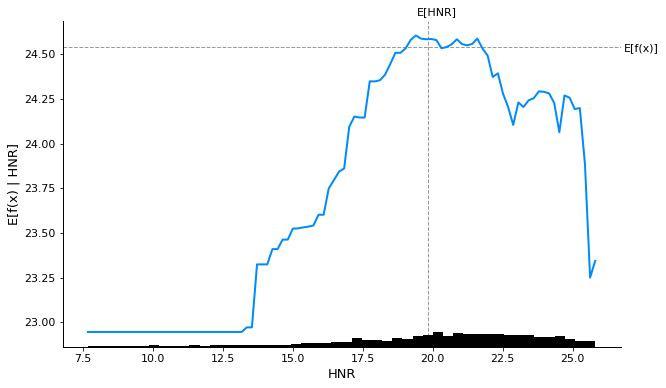

In [63]:
shap.partial_dependence_plot(
    ind = 'HNR',
    model = xgb_mod.predict,
    features = X_test.values,
    shap_values = shap_values[100],
    feature_names= X_test.columns,
    xmin = 'percentile(5)',
    xmax = 'percentile(95)',
    model_expected_value=True,
    feature_expected_value=True)

## Biểu đồ Decision plot

Một cách khác để giải nghĩa mô hình ở cấp độ quần thể và cá thể, đó là dùng decision plot.

Cấu trúc biểu đồ như sau:

+ Trục X biểu thị thang đo của kết quả dự báo (xác suất 0:1 cho bài toán classification), kết quả hàm f(X) cho bài toán hồi quy).

+ Trục Y trình bày danh sách các features, sắp xếp theo mức độ đóng góp/tầm quan trọng. feature càng quan trọng được xếp trên, feature dóng góp yếu hơn ở dưới.

+ Một phổ màu liên tục trình bày kết quả dự báo, nằm phía trên biểu đồ, mỗi giá trị được mã hóa 1 màu khác nhau và người dùng có thể tùy chỉnh phổ màu này theo ý thích.

+ Yếu tố hình họa là 1 biểu đồ tuyến kí, mang lại hình ảnh 1 con đường, dẫn từ vị trí của base value của hàm f(X), lúc chưa có 1 feature nào tham gia, sau đó mỗi bước đi trên con đường này ta đưa 1 feature tham gia vào mô hình, từ yếu đến mạnh. Mỗi feature sẽ kéo ta đi về bên trái hay phải thang đo của outcome, tùy theo liên hệ giữa outcome và feature đó, lực kéo cũng mạnh hay yếu khác nhau. feature càng quan trọng kéo càng mạnh, dẫn ta đi càng xa. Cuối cùng, feature mạnh nhất quyết định sẽ dẫn ta đến 1 vị trí trên thang đo outcome, chính là kết quả dự báo sau cùng.

Biểu đồ này cực kì lợi hại cho bài toán phân loại, vì nó cho phép giải thích kết quả của mô hình cho từng cá thể một cách trực quan và dễ hiểu. Cho bài toán hồi quy thì thông điệp cũng tương tự

Khi diễn giải cho cá thể, chỉ có 1 con đường được vẽ, và được dán label kèm theo là giá trị mỗi feature, khi áp dụng cho quần thể, nhiều con đường chồng lên nhau và người dùng có thể thay đổi giá trị alpha để nhìn rõ hơn.

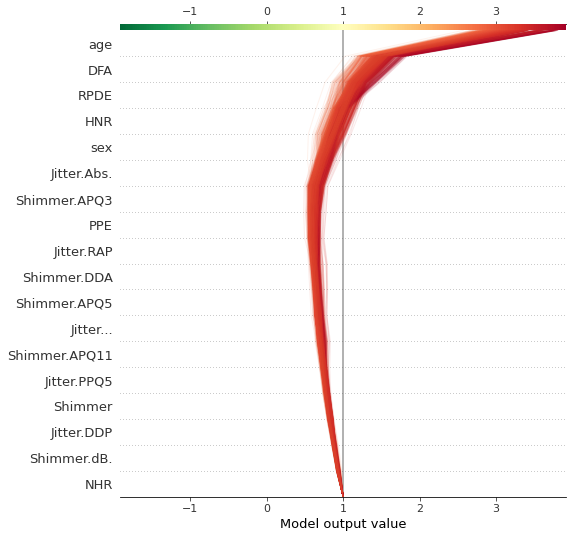

In [173]:
shap.decision_plot(base_value = explainer.expected_value, 
                   shap_values = shap_values, 
                   feature_order='importance', # hclust
                   feature_names = list(X_test.columns),
                   features = X_test,
                   plot_color='RdYlGn_r',
                   alpha = 0.1,
                   link='identity',
                  new_base_value = True)

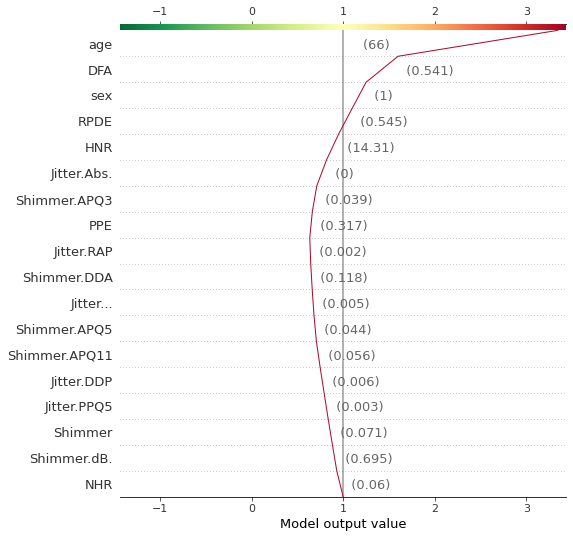

In [98]:
idx = 100

shap.decision_plot(base_value = explainer.expected_value, 
                   shap_values = shap_values[idx], 
                   feature_order='importance', # hclust
                   feature_names = list(X_test.columns),
                   features = X_test.iloc[idx],
                   # xlim = (min(y_test), max(y_test)),
                   plot_color='RdYlGn_r',
                   alpha = 1.0,
                   link='identity',
                  new_base_value = True)

## Biểu đồ tương quan feature/shape score

Ngoài tương quan bộ phận, shap còn dựng biểu đồ tương quan giữa 1 feature bất kì và shap score của chính feature đó.

Công dụng của biểu đồ này cho phép khảo sát quy luật liên hệ giữa giá trị 1 feature và sự đóng góp của feature đó qua điểm shap score.

Cấu tạo của biểu đồ như sau:

+ Trục X biểu thị thang đo của feature được khảo sát

+ Trục Y biểu thị thang đo của shap score của feature đó

+ yếu tố hình họa là điểm (biểu đồ tán xạ), mỗi điểm được tô màu tùy theo 1 feature khác trong dữ liệu, thang đo là biểu kiến.

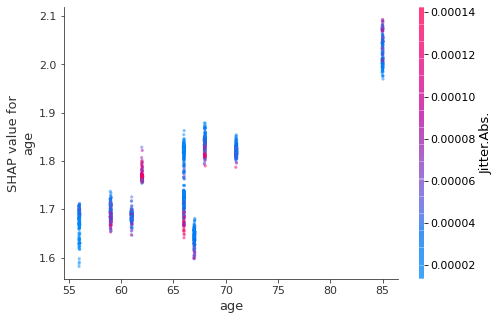

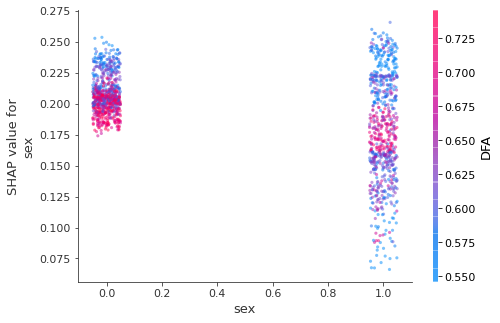

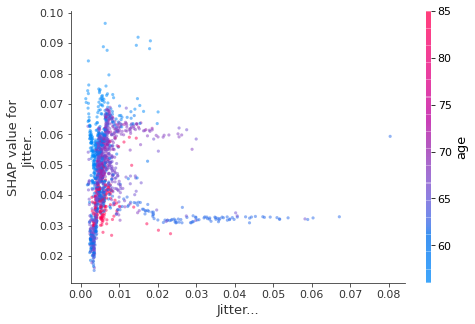

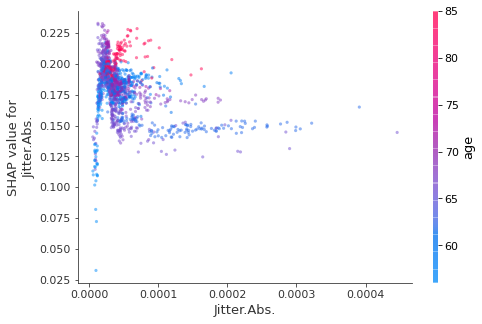

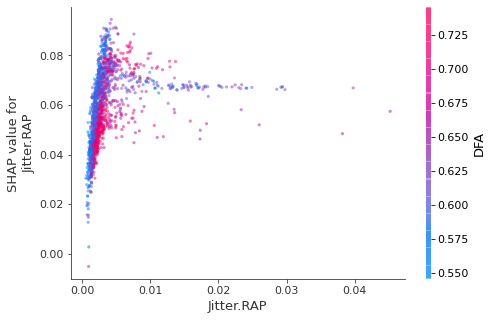

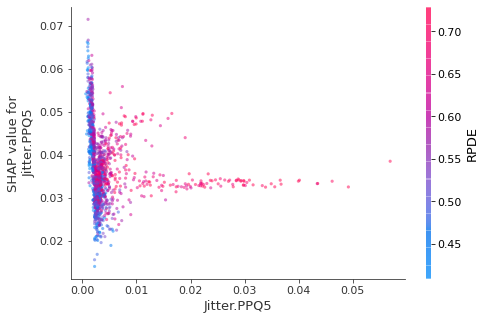

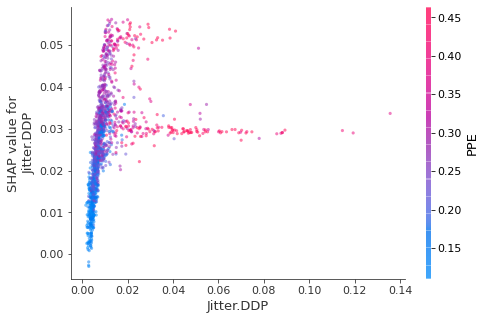

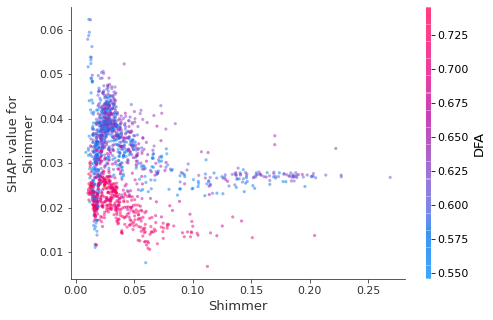

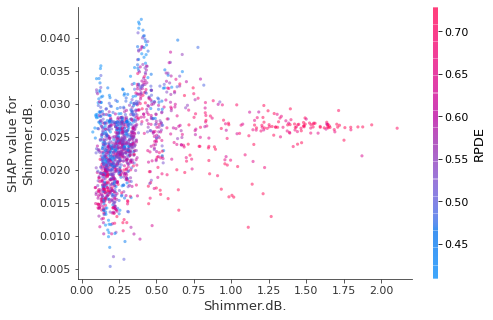

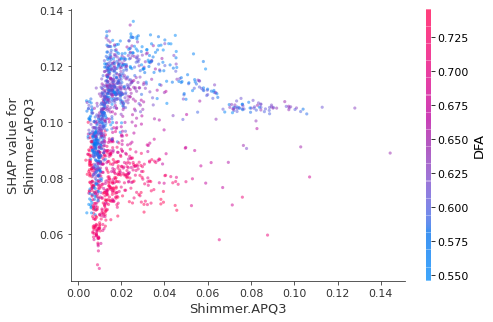

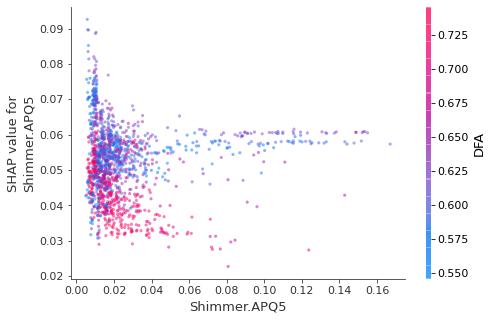

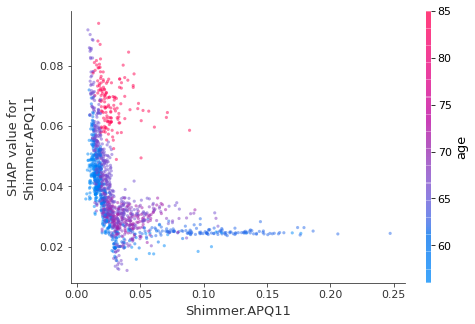

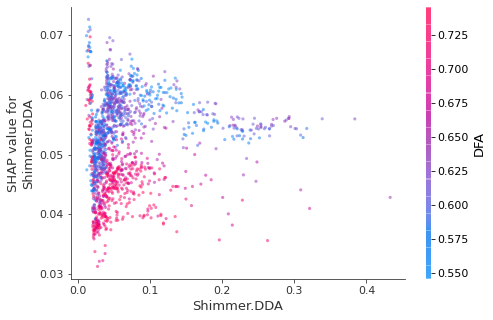

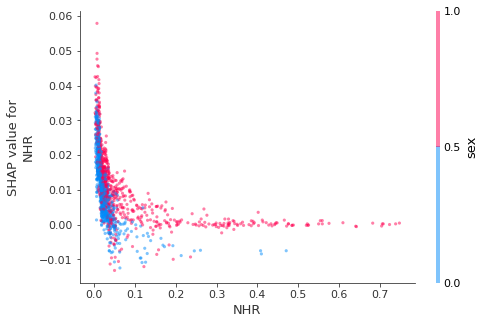

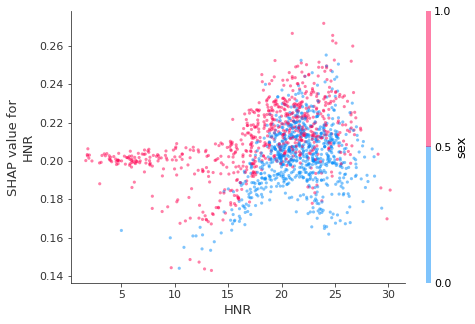

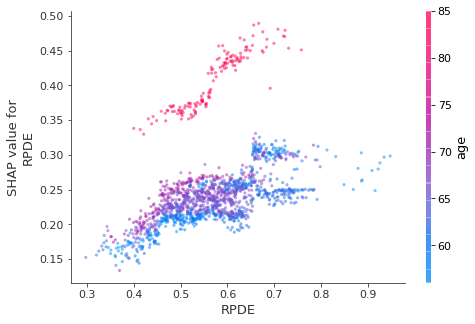

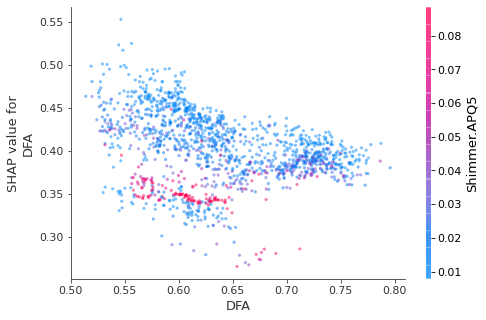

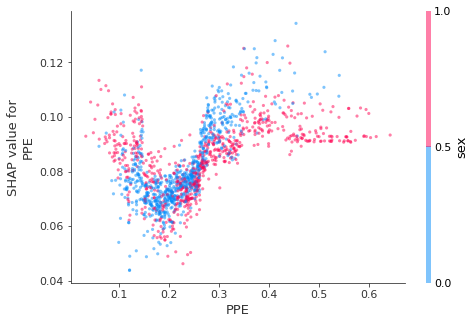

In [110]:
for name in X_test.columns:
    shap.dependence_plot(ind = name,
                    shap_values = shap_values,
                    features = X_test.values,
                     feature_names = list(X_test.columns),
                     display_features = X_test,
                     dot_size = 10,
                     x_jitter = 0.1,
                     alpha = 0.5,
                    )

## Biểu đồ force_plot

Biểu đồ force plot có ý nghĩa tương tự như decision plot, nhưng thay vì hình ảnh một cuộc dạo chơi trên con đường, với các bước đi rẽ trái, rẽ phải... thì ta có hình ảnh khác là một cuộc thi kéo co hoặc 2 nhóm người đang giành nhau một vật. Mỗi đội cùng kéo hoặc đẩy; tương ứng với hiệu quả của feature làm tăng, giảm kết quả dự báo

Có thể hình dung đây là biểu đồ waterfall plot được nén ép lại.

Cấu tạo của biểu đồ rất đơn giản, nó chỉ có 1 chiều là thang đo của kết quả dự báo, lức kéo/đẩy của mổi feature được hiển thị bằng kích thước mũi tên, và mũi tên được tô màu theo chiều tăng/giảm. Chỉ có giá trị các features quan trọng nhất được thể hiện.

Tương tự waterfall plot và decision plot, force plot dùng để diễn giải ở cấp độ cá thể, và nó rất hiệu quả.

In [131]:
case = 10

shap.force_plot(base_value = explainer.expected_value, 
                shap_values = shap_values[case],
                features =  X_test.values[case],
                feature_names = list(X_test.columns),
                link = 'identity',
                figsize = (10,15),
                plot_cmap= 'RdYlGn_r')

Ta cũng có thể áp dụng forceplot cho quần thể, lúc này các mũi tên được thay bằng area plot, trục X biểu thị cho danh sách các trường hợp: 

Đây là 1 biểu đồ tương tác, ta có thể chọn giá trị trên trục Y.

Công dụng của biểu đồ này để khảo sát tổng thể phân bố của shap score trong quần thể.

In [132]:
shap.force_plot(base_value = explainer.expected_value, 
                shap_values = shap_values,
                features =  X_test.values,
                feature_names = list(X_test.columns),
                link = 'identity',
                figsize = (10,15),
                plot_cmap= 'RdYlGn_r')

## Khảo sát sự tương tác giữa các cặp features

Quy trình shap đã tạo ra cho mỗi features và mỗi instance một trị số thống kê là shap score. Trị số này đo lường mức độ đóng góp của feature đó cho cá thể đó, vào kết quả dự báo của mô hình.

Khi 2 features hợp tác hay đối kháng với nhau, sẽ dẫn đến tương quan thuận hay nghịch giữa 2 shap score của chúng, lợi dụng đặc tính này, ta có thể khảo sát quan hệ tương tác giữa 1 feature này và 1 feature khác

Kết quả khảo sát có dạng 1 ma trận giống như ma trận tương quan, được tạo ra nhờ method shap_interaction của object explainer.

Sau khi xuất ra interaction matrix,ta có thể dùng 2 dạng biểu đồ để khảo sát trực quan:

In [147]:
shap_interaction_values = explainer.shap_interaction_values(X_test.values)

### Biểu đồ Interaction dạng scatter plot

Kiểu thứ nhất có dạng 1 biểu đồ tán xạ, với cấu tạo nhiều panel, mỗi panel khảo sát 1 feature, tương tác với những feature còn lại. Trục X biểu diễn thang đo interaction score (tương đương với hệ số tương quan r, trong khoàng -1/1), trục Y là danh sách các feature. Mỗi điểm là 1 instance trong dữ liệu.

Các điểm sẽ có khuynh hướng gom lại thành cụm, và trọng tâm của cụm sẽ định vị mức độ tương tác trung bình trên thang đo.

Interaction gần 1 là hợp tác, interaction gần -1 là đối nghịch, interaction = 0 là không có tương tác.

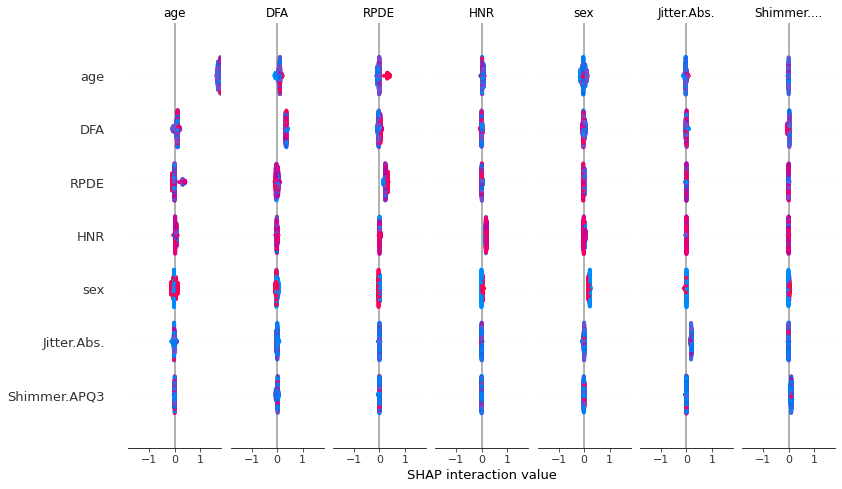

In [150]:
shap.summary_plot(shap_interaction_values, 
                   features = X_test)

Do interaction matrix chính là 1 correlation matrix, ta có dạng biểu đồ thứ 2 là 1 heatmap, có thể vẽ bằng seaborn một cách dễ dàng:

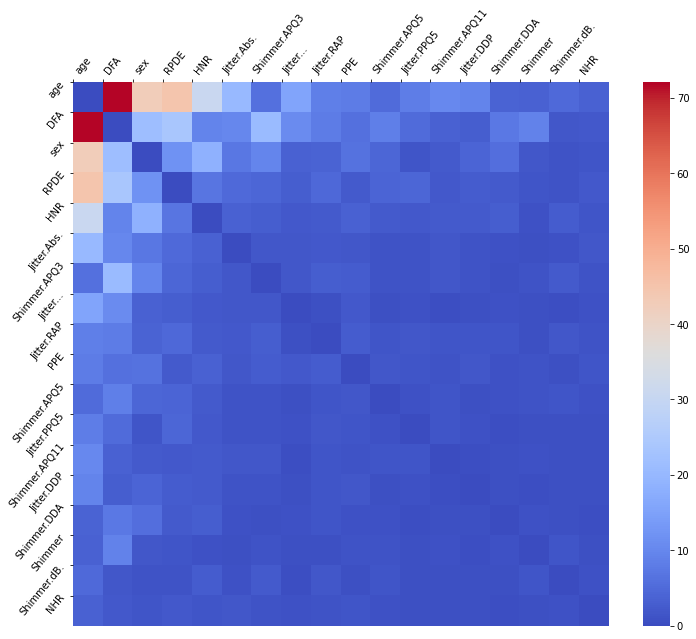

In [160]:
tmp = np.abs(shap_interaction_values).sum(0)
for i in range(tmp.shape[0]):
    tmp[i,i] = 0
inds = np.argsort(-tmp.sum(0))
tmp2 = tmp[inds,:][:,inds]

plt.figure(figsize=(12,10))

sns.heatmap(tmp2, cmap = 'coolwarm')
plt.yticks(range(tmp2.shape[0]), X_test.columns[inds], rotation=50.4, horizontalalignment="right")
plt.xticks(range(tmp2.shape[0]), X_test.columns[inds], rotation=50.4, horizontalalignment="left")
plt.gca().xaxis.tick_top()

# Bàn luận

Một cách tổng quát, shap thực sự là một phương pháp rất mạnh và phổ quát, cho phép diễn giải bất kì một algorithm nào cho bài toán hồi quy. Việc diễn giải này cho phép trả lời hàng loạt câu hỏi như:

Mô hình này chính xác đến đâu ? Có đáng tin cậy hay không ?

Mô hình hoạt động như thế nào ? Nó đã học được gì từ dữ liệu ? Giải đáp được câu hỏi này cho phép rút ra hàng loạt thông tin, suy diễn quan trọng, hữu ích bao gồm: Vai trò của mỗi biến ? Mối liên hệ bộ phận giữa mỗi biến và kết quả là gì ? những feature nào là quan trọng nhất ? Chúng hợp tác với nhau như thế nào ?

Giải thích được cơ chế của mô hình ở cấp độ cá thể: Mô hình hoạt động có chính xác không cho trường hợp này ? Tại sao kết quả lại như vậy ? Biến nào có vai trò/ ảnh hưởng quan trọng nhất ở cá thể này ?

Kỹ thuật shap mở ra cánh cửa đến một thời kì mới, mà mô hình hồi quy tuyến tính, các thiết kế ANOVA, ... không còn là sự lựa chọn duy nhất cho nghiên cứu Y học. Nhiều mô hình khác vốn thuộc về trường phái Statistical learning hay Machine learning cũng có thể được dùng như công cụ để suy diễn thống kê và khai thác thông tin từ dữ liệu thực nghiệm. Thậm chí những mô hình vốn được xem là hộp đen cũng có thể được phân tích về cấu trúc bên trong, cũng như giải thích được cơ chế hoạt động một cách trực quan.

Việc diễn giải cho cá thể có ý nghĩa lâm sàng rất quan trọng, vì thống kê quy ước chưa bao giờ cho phép ta làm được điều này (thí dụ các mô hình logistic, hay hồi quy Cox chỉ được diễn giải cho quần thể). 